<a href="https://colab.research.google.com/github/Nataleca/DiplomadoIAAP-Grupo3/blob/main/ProcesamientoLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import re

#from bs4 import BeautifulSoup as bs
#import requests


import string
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud,STOPWORDS
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/IA y AP/restaurant_reviews_clean.csv')

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Nombre,Título,Fecha,Rating,Reviews,Tipo,reviews_limpios
0,0,0,Casa Vieja Restaurante,Comida Tiquita en un ambiente muy colombiano,15 de octubre de 2019,50,Tuve la experiencia de ir almozar a este típic...,"Colombiana, Sudamericana",experiencia almozar típico restaurante colombi...
1,1,1,Casa Vieja Restaurante,Me gustó!!,22 de octubre de 2018,40,"El restaurante es agradable, antiguo y familia...","Colombiana, Sudamericana",restaurante agradable antiguo familiar persona...
2,2,2,Casa Vieja Restaurante,Restaurante tradicional frente al Hotel Tequen...,18 de septiembre de 2018,40,"Llegamos tarde como a las 17 horas, ya no habí...","Colombiana, Sudamericana",llegamos tarde horas público atendieron bien c...
3,3,3,Casa Vieja Restaurante,QUE GRATO VOLVER,4 de agosto de 2016,50,Hace años no disfrutaba de un almuerzo en este...,"Colombiana, Sudamericana",hace años disfrutaba almuerzo agradable restau...
4,4,4,Casa Vieja Restaurante,Un clásico que no defrauda,1 de agosto de 2016,40,Lugar típico de cocina colombiana que uno no p...,"Colombiana, Sudamericana",lugar típico cocina colombiana puede dejar vis...


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [ ]:
df.head()

,Nombre,Título,Fecha,Rating,Reviews,Tipo,reviews_limpios
0,Casa Vieja Restaurante,Comida Tiquita en un ambiente muy colombiano,15 de octubre de 2019,50,Tuve la experiencia de ir almozar a este típic...,"Colombiana, Sudamericana",experiencia almozar típico restaurante colombi...
1,Casa Vieja Restaurante,Me gustó!!,22 de octubre de 2018,40,"El restaurante es agradable, antiguo y familia...","Colombiana, Sudamericana",restaurante agradable antiguo familiar persona...
2,Casa Vieja Restaurante,Restaurante tradicional frente al Hotel Tequen...,18 de septiembre de 2018,40,"Llegamos tarde como a las 17 horas, ya no habí...","Colombiana, Sudamericana",llegamos tarde horas público atendieron bien c...
3,Casa Vieja Restaurante,QUE GRATO VOLVER,4 de agosto de 2016,50,Hace años no disfrutaba de un almuerzo en este...,"Colombiana, Sudamericana",hace años disfrutaba almuerzo agradable restau...
4,Casa Vieja Restaurante,Un clásico que no defrauda,1 de agosto de 2016,40,Lugar típico de cocina colombiana que uno no p...,"Colombiana, Sudamericana",lugar típico cocina colombiana puede dejar vis...


In [ ]:
# Asignamos polaridad por rating
def polarity_to_label(x):
    if(x <= 20):
        return 'negative'
    if(x == 30):
        return 'neutral'
    if(x >= 40):
        return 'positive'
df['etiquetas'] = df.Rating.apply(polarity_to_label)

In [ ]:
# Agrupamos por etiqueta positiva
is_positive = df.loc[:, 'etiquetas'] == 'positive'
df_positive = df.loc[is_positive]
df_positive.head()
print('\n', df_positive.shape)


 (36323, 8)


In [ ]:
#  Agrupamos por etiqueta neutral
is_neutral = df.loc[:, 'etiquetas'] == 'neutral'
df_neutral = df.loc[is_neutral]
df_neutral.head()
#print('\n', df_neutral.shape)

,Nombre,Título,Fecha,Rating,Reviews,Tipo,reviews_limpios,etiquetas
10,Casa Vieja Restaurante,comida típica,17 de marzo de 2015,30,Creo que ya pasó de moda. No lo han actualizad...,"Colombiana, Sudamericana",creo pasó moda actualizado deben mejorar prese...,neutral
57,Villanos En Bermudas,Mes,3 de febrero de 2019,30,Buenas tardes. Ayer fui a Villanos en Bermudas...,Organica,buenas tardes ayer villanos bermudas gustó ser...,neutral
59,Villanos En Bermudas,Experiencia de usuario no atendido,25 de enero de 2019,30,Tuvimos una experiencia el año pasado con vari...,Organica,experiencia pasado varios amigos deferentes fa...,neutral
71,Villanos En Bermudas,Flojo aunque diferente,29 de agosto de 2018,30,"Excelente cóctel de la casa, son 10 platos exp...",Organica,excelente cóctel casa platos experimentales bu...,neutral
72,Villanos En Bermudas,ES MAS LA EXPECTATIVA QUE LA REALIDAD,27 de agosto de 2018,30,"Al ir tenia una expectativa grande, y cada vez...",Organica,tenia expectativa grande cada iban pasando pla...,neutral


In [ ]:
# Agrupamos por etiqueta negativa
is_negative = df.loc[:, 'etiquetas'] == 'negative'
df_negative = df.loc[is_negative]
df_negative.head()
print('\n', df_negative.shape)


 (3883, 8)


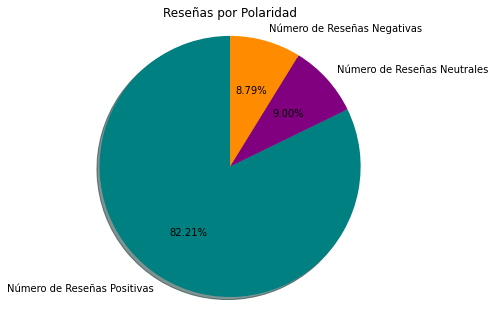

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(df_positive), len(df_neutral), len(df_negative)]

ax.pie(values, 
       labels = ['Número de Reseñas Positivas', 'Número de Reseñas Neutrales','Número de Reseñas Negativas'],
       colors=['teal', 'purple','darkorange'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Reseñas por Polaridad');

In [ ]:
rating=df['Rating']
print(rating.describe())

count    44183.000000
mean        42.275536
std         10.848959
min         10.000000
25%         40.000000
50%         50.000000
75%         50.000000
max         50.000000
Name: Rating, dtype: float64


In [ ]:
import collections
counter=collections.Counter(rating)
print(counter)

Counter({50: 23961, 40: 12362, 30: 3977, 10: 2164, 20: 1719})


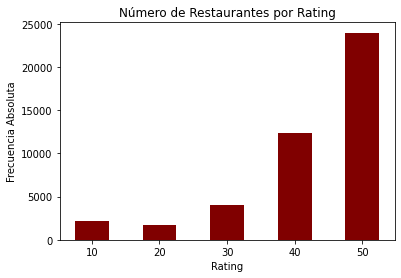

In [ ]:
ejex=list(counter.keys())
ejey=list(counter.values())
plt.bar(ejex, ejey,color ='maroon',width = 5)
plt.ylabel('Frecuencia Absoluta')
plt.xlabel('Rating')
plt.title('Número de Restaurantes por Rating')
plt.show()

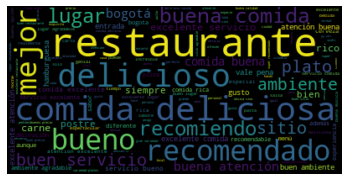

In [ ]:
words_positive = ' '.join(df_positive['reviews_limpios'])
wordcloud_pos=WordCloud().generate(words_positive)
plt.imshow(wordcloud_pos,interpolation='bilinear')
plt.axis('off')
plt.show()

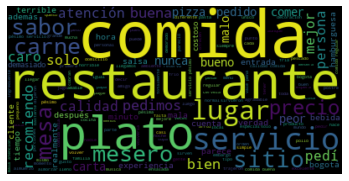

In [ ]:
words_negative = ' '.join(df_negative['reviews_limpios'])
wordcloud_neg=WordCloud().generate(words_negative)
plt.imshow(wordcloud_neg,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

#Create two new columns
df['reviews_limpios'] = df['reviews_limpios'].astype(str)
df['Subjectivity'] = df['reviews_limpios'].apply(subjectivity)
df['Polarity'] = df['reviews_limpios'].apply(polarity)
df.head()

,Nombre,Título,Fecha,Rating,Reviews,Tipo,reviews_limpios,etiquetas,Subjectivity,Polarity
0,Casa Vieja Restaurante,Comida Tiquita en un ambiente muy colombiano,15 de octubre de 2019,50,Tuve la experiencia de ir almozar a este típic...,"Colombiana, Sudamericana",experiencia almozar típico restaurante colombi...,positive,0.0,0.0000
1,Casa Vieja Restaurante,Me gustó!!,22 de octubre de 2018,40,"El restaurante es agradable, antiguo y familia...","Colombiana, Sudamericana",restaurante agradable antiguo familiar persona...,positive,0.4,0.1875
2,Casa Vieja Restaurante,Restaurante tradicional frente al Hotel Tequen...,18 de septiembre de 2018,40,"Llegamos tarde como a las 17 horas, ya no habí...","Colombiana, Sudamericana",llegamos tarde horas público atendieron bien c...,positive,0.0,0.0000
3,Casa Vieja Restaurante,QUE GRATO VOLVER,4 de agosto de 2016,50,Hace años no disfrutaba de un almuerzo en este...,"Colombiana, Sudamericana",hace años disfrutaba almuerzo agradable restau...,positive,0.0,0.0000
4,Casa Vieja Restaurante,Un clásico que no defrauda,1 de agosto de 2016,40,Lugar típico de cocina colombiana que uno no p...,"Colombiana, Sudamericana",lugar típico cocina colombiana puede dejar vis...,positive,0.0,0.0000


In [ ]:
is_negative = df.loc[:, 'etiquetas'] == 'negative'
df_negative = df.loc[is_negative]
df_negative.head()

,Nombre,Título,Fecha,Rating,Reviews,Tipo,reviews_limpios,etiquetas,Subjectivity,Polarity
36,Villanos En Bermudas,Peor experiencia de mi vida! Villanos de verdad,22 de septiembre de 2019,10,He estado en muchas restaurantes en diferentes...,Organica,muchas restaurantes diferentes partes mundo lu...,negative,0.30,1.00
38,Villanos En Bermudas,Terrible,30 de julio de 2019,10,Un intento gastronómico que no entiendo cómo e...,Organica,intento gastronómico entiendo cómo best mezcla...,negative,0.30,1.00
40,Villanos En Bermudas,Normal y muy caro para lo que es. No volveríamos,6 de julio de 2019,10,El mesero que nos atendió una persona de orige...,Organica,mesero atendió persona origen francés amable e...,negative,0.65,0.15
48,Villanos En Bermudas,Celebración,24 de abril de 2019,10,Las mismas niñas que cocinan y montan los plat...,Organica,mismas niñas cocinan montan platos mismas rest...,negative,0.00,0.00
49,Villanos En Bermudas,SITIO SOBREVALORADO,18 de abril de 2019,20,"En una cena de 10/12 bocados, 5 tenían queso d...",Organica,cena bocados queso cabra pasa buen restaurante...,negative,0.00,0.00


In [ ]:
def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [ ]:
# plot the polarity and subjectivity
fig = px.scatter(df, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

In [ ]:
spanish_stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')
non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))
stemmer = SnowballStemmer('spanish')
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning:

Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:440: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:93: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence 

The shape of the tfidf is (3883, 961), meaning that there are 3883 Reviews and 961 tokens made through the filtering process.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:818: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Model Log Likelihood Score:  -21380.646181248863
Model Perplexity:  1736.312040715631


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:440: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:93: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes

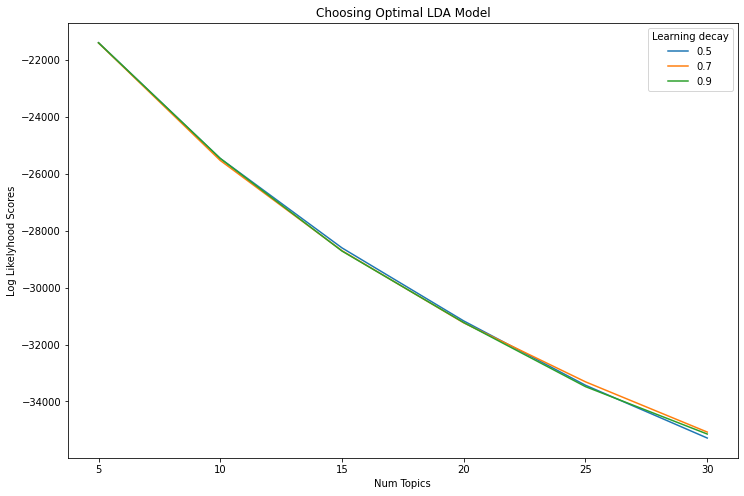

In [ ]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df_review, review_colname):
    '''
    INPUTS:
        df_review - dataframe that contains the reviews
        review_colname: name of column that contains reviews
        
    OUTPUTS:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    docs_raw = df_review[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(analyzer = 'word',
                                    stop_words = spanish_stopwords,
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df_negative, 'Reviews')



In [ ]:
#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,comida,33.0,comida,54.3,comida,64.5,servicio,45.6,pedido,21.0
1,carne,26.7,calidad,38.6,lugar,47.4,restaurante,35.4,servicio,20.5
2,restaurante,23.2,precio,36.5,servicio,45.9,minutos,32.0,comida,20.0
3,falta,21.8,servicio,34.1,mala,34.9,mesa,31.5,hora,16.5
4,sabor,21.8,sabor,33.1,restaurante,34.4,comida,31.0,restaurante,15.9
5,plato,20.8,platos,30.7,precios,29.9,dos,30.9,nadie,13.3
6,sitio,20.7,buena,29.9,calidad,27.4,mal,30.1,mas,13.1
7,servicio,19.8,carne,24.5,mal,24.2,platos,29.3,desmejorado,12.8
8,lugar,18.2,regular,24.5,ser,22.1,nunca,28.5,calidad,12.7
9,arroz,17.6,pena,23.0,bien,21.8,meseros,24.1,platos,12.7


In [ ]:
# Topic Modelling Visualization for the Negative Reviews
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.121428 -0.053175       1        1  23.080147
2     -0.070094 -0.089077       2        1  21.707448
0     -0.010821  0.012021       3        1  19.842046
1     -0.118360  0.049921       4        1  19.715605
4      0.077848  0.080310       5        1  15.654755, topic_info=        Term       Freq       Total Category  logprob  loglift
647     pena  23.000000   23.000000  Default  30.0000  30.0000
913     vale  23.000000   23.000000  Default  29.0000  29.0000
691   precio  59.000000   59.000000  Default  28.0000  28.0000
642   pedido  46.000000   46.000000  Default  27.0000  27.0000
559  minutos  49.000000   49.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
548    mesas   8.697449   30.329583   Topic5  -5.3734   0.6053
691   precio   9.904098   59.362621   Topic5  -5.2435   0.0637
547     mesa